In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Optimizer, Adam,RMSprop, SGD
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
#import argparse
import os
import math

In [3]:
# Class for the optimizer Itao ( a new Iterative thresholding algorithm based optimizer)
class Itao(Optimizer):
    def __init__(self, k=10.0, lamda=0.00001, name="Itao", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self._set_hyper("k", k) # tuning hyperparameter K
        self._set_hyper("lamda", lamda) # Tikhonov parameter lamda
        
    

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        
        var_dtype = var.dtype.base_dtype
        k = self._get_hyper("k", var_dtype)
        lamda = self._get_hyper("lamda", var_dtype)
        new_var = (k/(k+lamda))*var - grad/(k+lamda) # update variables
        var.assign(new_var)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "k": self._serialize_hyperparameter(self._k),
            "lamda": self._serialize_hyperparameter(self._lamda),
            
        }
    def get_config(self):
        config = super(Itao, self).get_config()
        config.update({
            "k": self._serialize_hyperparameter("k"),
            "lamda": self._serialize_hyperparameter("lamda"),
            
        })
        return config

In [4]:
data_train = np.load('new_3000_data_train_224.npy')
labels_train = np.load('new_3000_labels_train_224.npy')

In [5]:
#Shuffling Data
np.random.seed(12345)
indx=np.arange(data_train.shape[0])          
np.random.shuffle(indx)
data_train = data_train[indx]
labels_train = labels_train[indx]

In [6]:
labels = np.argmax(labels_train, axis=1)
labels.shape

(3000,)

In [7]:
from sklearn.metrics import roc_auc_score
from utils import roc_curv_plot
from utils import evaluation_metrics

In [8]:
from sklearn.model_selection import KFold, StratifiedKFold
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)

19/19 [==============================] - 9s 107ms/step - loss: 0.1417 - acc: 0.9950
[0.14171075820922852, 0.9950000047683716]
[INFO] evaluating network...Fold: 1
              precision    recall  f1-score   support

       covid       1.00      0.98      0.99       200
      normal       0.99      1.00      1.00       200
       viral       1.00      1.00      1.00       200

    accuracy                           0.99       600
   macro avg       1.00      0.99      0.99       600
weighted avg       1.00      0.99      0.99       600



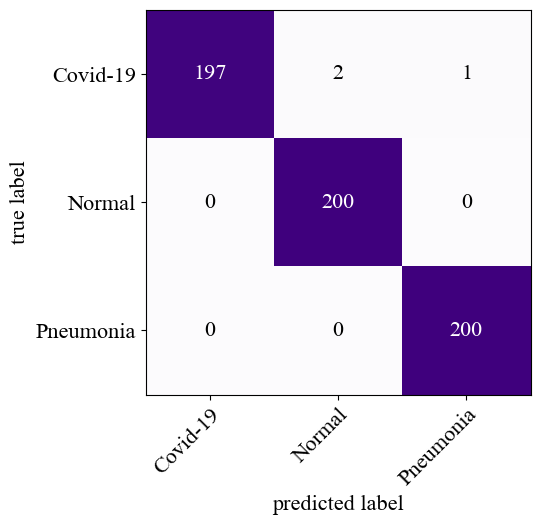

<Figure size 640x480 with 0 Axes>

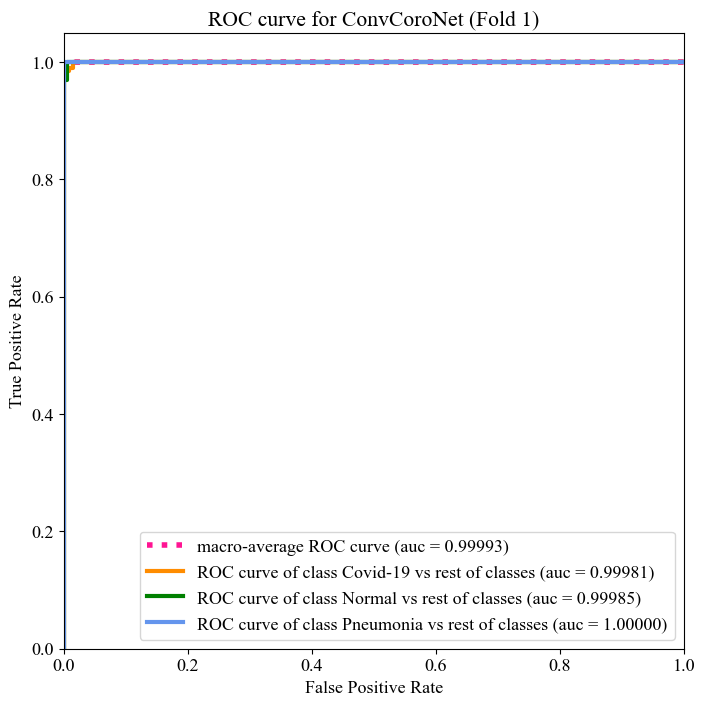

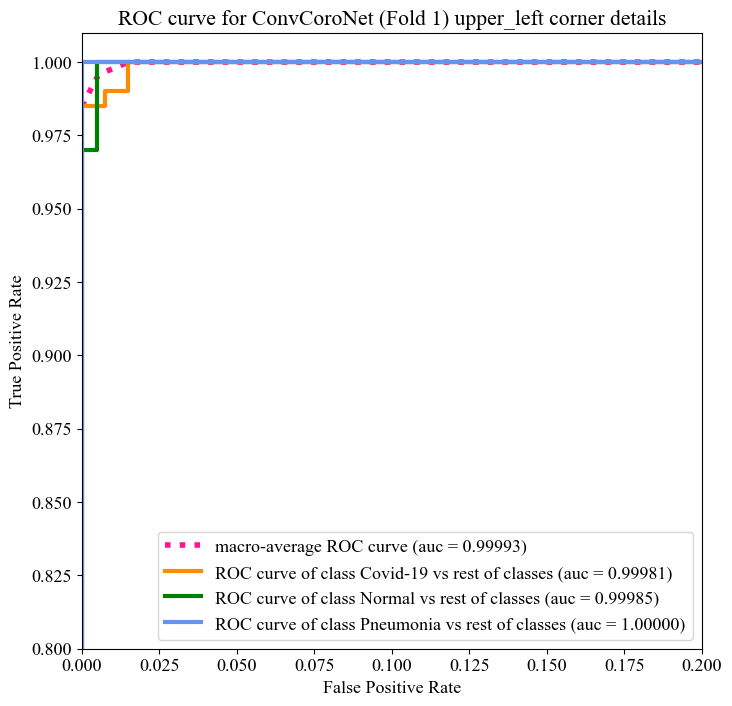

<Figure size 640x480 with 0 Axes>

score fold 1: 0.9998874999999999
19/19 [==============================] - 3s 57ms/step - loss: 0.1351 - acc: 0.9967
[0.13508044183254242, 0.996666669845581]
[INFO] evaluating network...Fold: 2
              precision    recall  f1-score   support

       covid       0.99      0.99      0.99       200
      normal       1.00      0.99      1.00       200
       viral       1.00      1.00      1.00       200

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



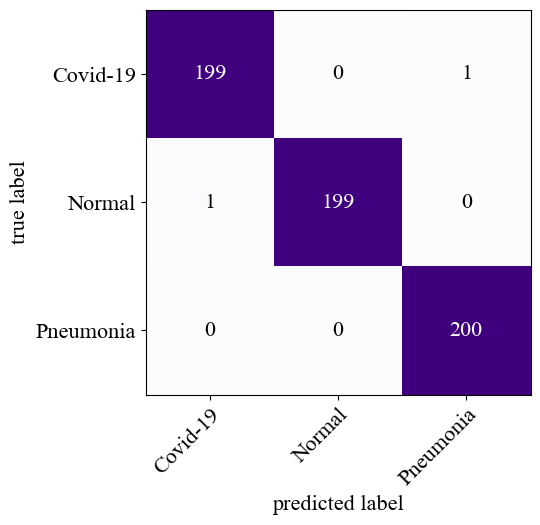

<Figure size 640x480 with 0 Axes>

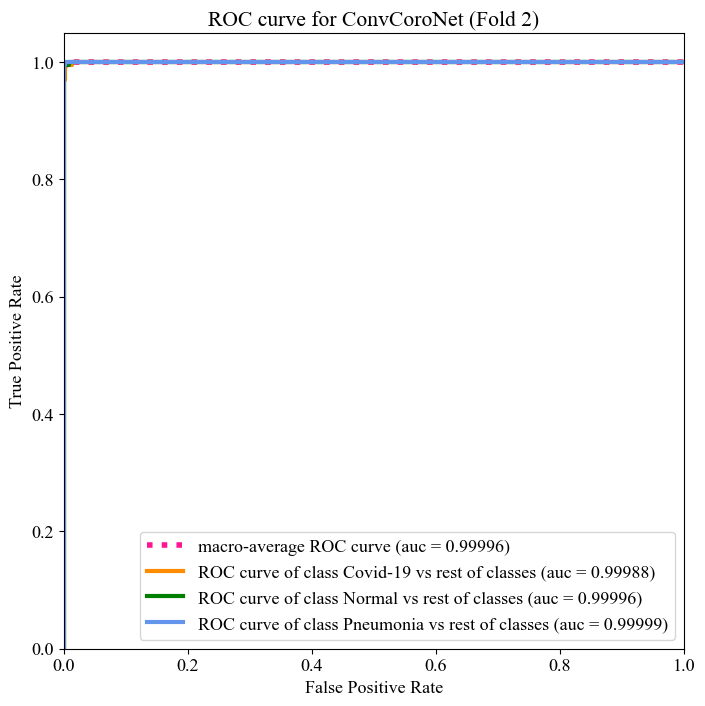

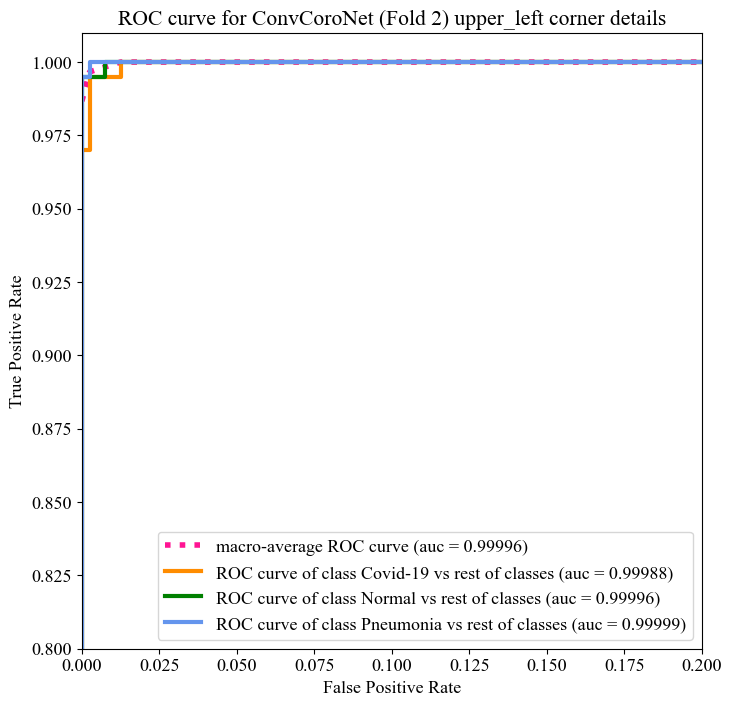

<Figure size 640x480 with 0 Axes>

score fold 2: 0.9999416666666668
19/19 [==============================] - 4s 56ms/step - loss: 0.2051 - acc: 0.9917
[0.2050667256116867, 0.9916666746139526]
[INFO] evaluating network...Fold: 3
              precision    recall  f1-score   support

       covid       0.99      0.98      0.99       200
      normal       1.00      0.99      0.99       200
       viral       0.99      1.00      0.99       200

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



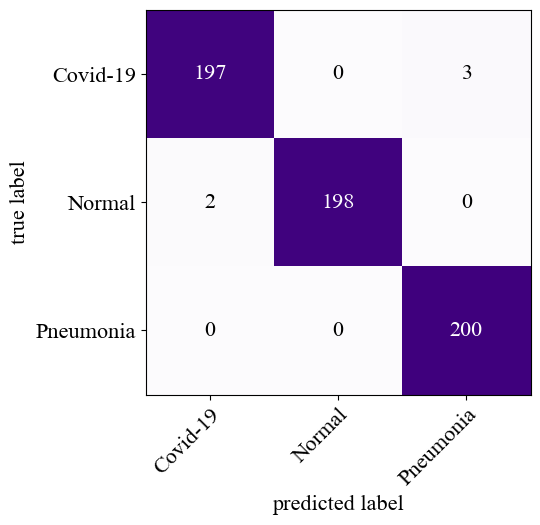

<Figure size 640x480 with 0 Axes>

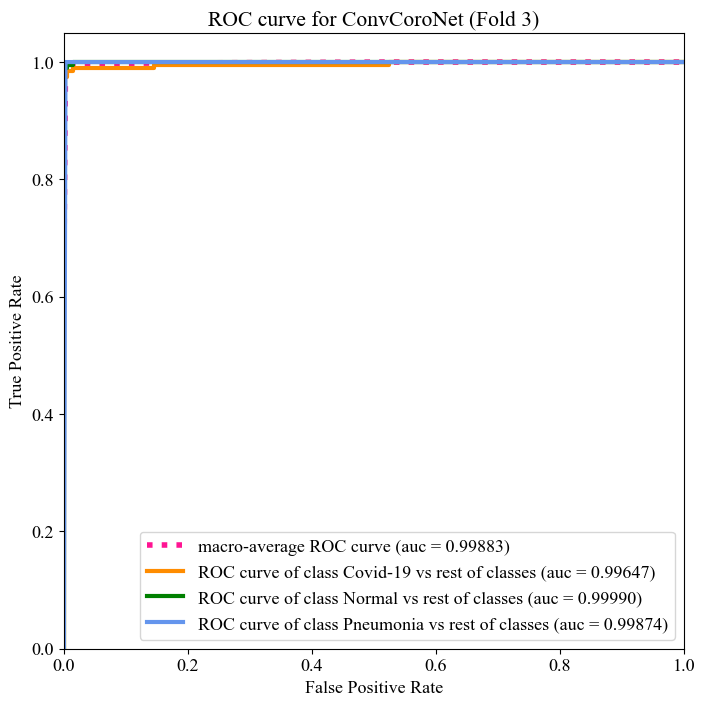

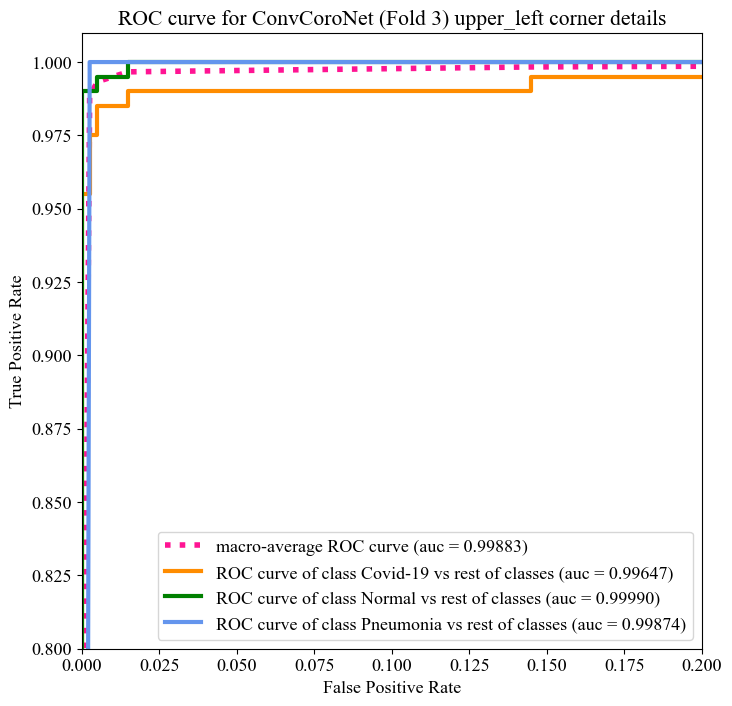

<Figure size 640x480 with 0 Axes>

score fold 3: 0.9983729166666667
19/19 [==============================] - 3s 56ms/step - loss: 0.1469 - acc: 0.9950
[0.14687171578407288, 0.9950000047683716]
[INFO] evaluating network...Fold: 4
              precision    recall  f1-score   support

       covid       1.00      0.98      0.99       200
      normal       0.99      1.00      1.00       200
       viral       1.00      1.00      1.00       200

    accuracy                           0.99       600
   macro avg       1.00      0.99      0.99       600
weighted avg       1.00      0.99      0.99       600



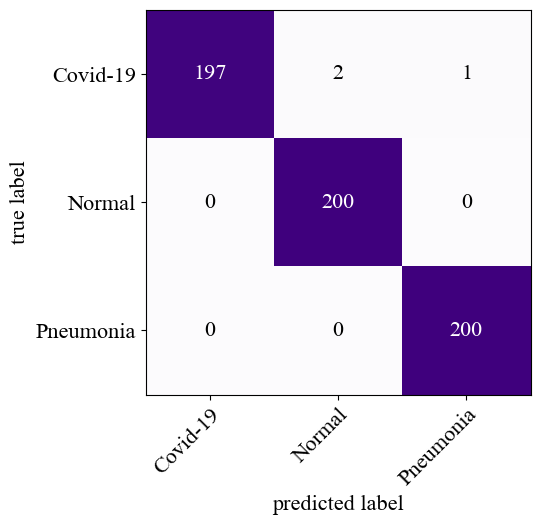

<Figure size 640x480 with 0 Axes>

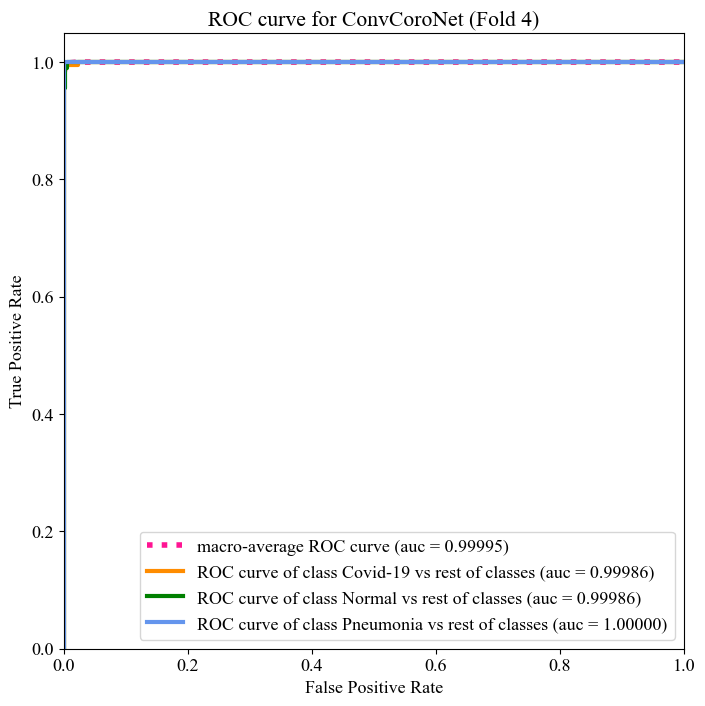

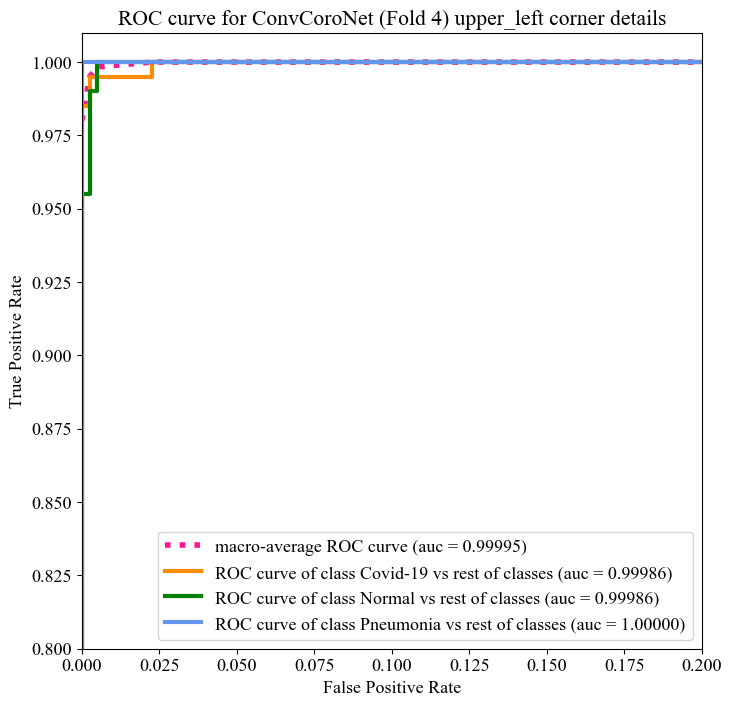

<Figure size 640x480 with 0 Axes>

score fold 4: 0.9999083333333333
19/19 [==============================] - 3s 55ms/step - loss: 0.1273 - acc: 0.9967
[0.1273244321346283, 0.996666669845581]
[INFO] evaluating network...Fold: 5
              precision    recall  f1-score   support

       covid       1.00      0.99      0.99       200
      normal       0.99      1.00      1.00       200
       viral       1.00      1.00      1.00       200

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



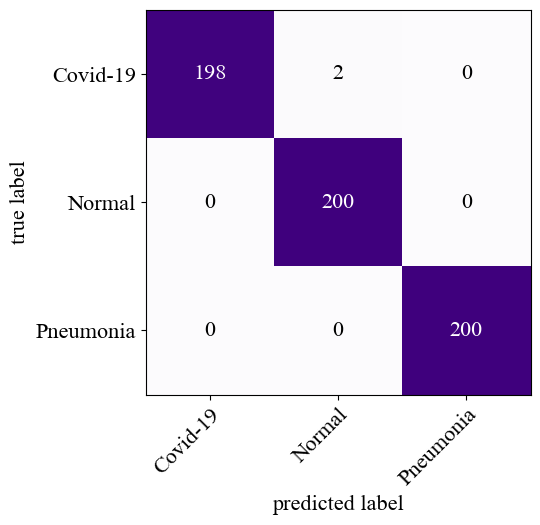

<Figure size 640x480 with 0 Axes>

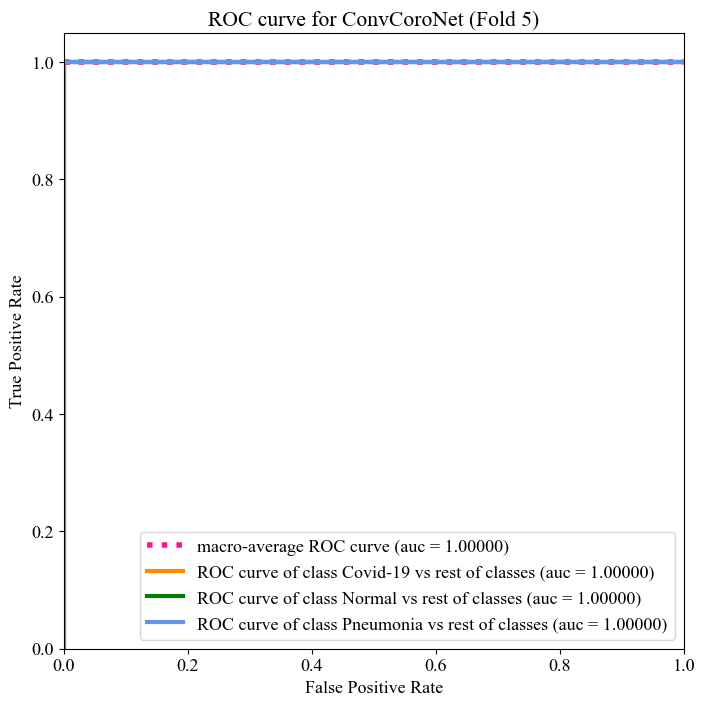

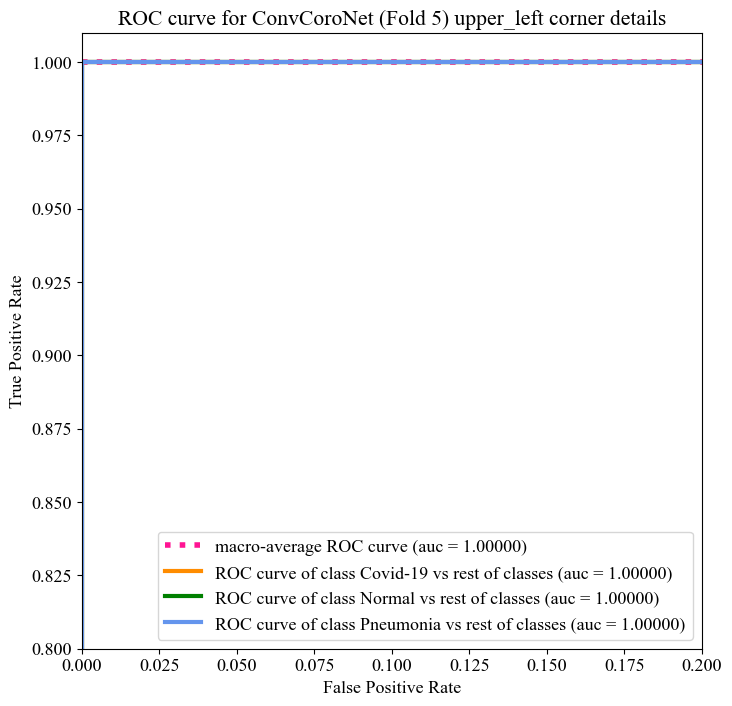

<Figure size 640x480 with 0 Axes>

score fold 5: 1.0
Average AUC: 0.9996220833333334


In [9]:
base_model = "InceptionV3"
save_dir = 'covid19_models_cross_val_InceptionV3/'
#base_model = "MobileNetV2"
#save_dir = 'covid19_models_cross_val_MobileNetV2/'
#base_model = "ResNet50V2"
#save_dir = 'covid19_models_cross_val_ResNet50V2/'
#base_model = "VGG16"
#save_dir = 'covid19_models_cross_val_VGG16/'
#base_model = "DenseNet121"
#save_dir = 'covid19_models_cross_val_DenseNet121/'

fold_var = 1
aucs = 0.0

tf.keras.backend.clear_session()
for train_index, val_index in skf.split(np.zeros(len(data_train)),labels):
  
    training_data = data_train[train_index]
    training_labels = labels_train[train_index]
    validation_data = data_train[val_index]
    validation_labels = labels_train[val_index]
  
    model = load_model(save_dir + 'model_' + base_model + '_fold_' + str(fold_var) + '.h5', compile=False)
    
    model.compile(loss="categorical_crossentropy", optimizer=Itao(), metrics=["acc"])
    #model.compile(loss="categorical_crossentropy", optimizer=RMSprop(), metrics=["acc"])
    #model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["acc"])
    #model.compile(loss="categorical_crossentropy", optimizer=SGD(), metrics=["acc"])
   
    print(model.evaluate(validation_data, validation_labels))
  
    evaluation_metrics(model, validation_data, validation_labels, fold_var, 32)
    
    predIdxs = model.predict(validation_data, batch_size=32)
  
    plt.figure()
    plt.show()
  
    roc_curv_plot(validation_labels, predIdxs, fold_var)
  
    plt.figure()
    plt.show()
  
    auc = roc_auc_score(validation_labels, predIdxs, multi_class='ovr', average='macro')
    aucs = aucs + auc
    print("score fold " + str(fold_var) + ": " + str(auc))
    
    tf.keras.backend.clear_session()
      
    fold_var = fold_var + 1
aucs = np.array(aucs)
print("Average AUC: " + str(aucs/5.0))

In [10]:
print("Average AUC: " + str(aucs/5.0))

Average AUC: 0.9996220833333334
